# Knowledge-Aware Recommender with Graph & Text Fusion


**Key Improvements over the Paper:**
1.  **Relational GAT (RGAT):** Instead of standard CompGCN, we use Attention *plus* Relation Embeddings. This allows the model to learn that for some movies, the "Director" edge is more important than the "Genre" edge.
2.  **Dual-View Text Encoding:** We handle Overviews and Reviews separately using a Hierarchical Attention mechanism.
3.  **Contrastive Learning (InfoNCE):** We add an auxiliary loss function that forces the Graph embeddings and Text embeddings of the same item to align in the latent space.

**Architecture:**
* **Input:** Heterogeneous Graph (DGL) + Text Features (Overviews, Reviews).
* **Graph Module:** Relational GAT layers.
* **Text Module:** SBERT embeddings -> Attention Aggregation.
* **Fusion:** Cross-Attention with Gating.
* **Loss:** BPR Loss (Ranking) + InfoNCE Loss (Contrastive).

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from utils.recomender_metrics import evaluate_recommendations, print_evaluation_results


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

EMBED_DIM = 64
HIDDEN_DIM = 128
ATTENTION_HEADS = 4
DROPOUT = 0.3
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 128 # Smaller batch size usually better for contrastive loss
TEXT_EMBED_PATH = '../data/processed/movie_text_embeddings.pt'

Using device: cpu


## 1. Data Preparation
We load the processed files and construct a Heterogeneous DGL Graph.
Ideally, we would load the `movie_knowledge_graph.graphml` directly, but mapping it to tensors for training is often cleaner when rebuilding from CSVs to ensure integer IDs are contiguous.


In [ ]:
def load_data_and_build_graph():
    print("Loading datasets...")
    
    movies_df = pd.read_csv('../data/processed/movies_graph_ready.csv')
    train_df = pd.read_csv('../data/raw/ml-100k/u1.base', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    test_df = pd.read_csv('../data/raw/ml-100k/u1.test', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    
    # auxiliary node files
    nodes_dir = '../data/processed/nodes'
    genres_df = pd.read_csv(f'{nodes_dir}/genres.csv')
    keywords_df = pd.read_csv(f'{nodes_dir}/keywords.csv')
    directors_df = pd.read_csv(f'{nodes_dir}/directors.csv')
    writers_df = pd.read_csv(f'{nodes_dir}/writers.csv')
    
    # --- ID MAPPING ---
    # Combined Users/Items to ensure consistency across Train/Test
    all_users = pd.concat([train_df['user_id'], test_df['user_id']]).unique()
    all_movies = movies_df['ml_movie_id'].unique()
    
    user_map = {uid: i for i, uid in enumerate(all_users)}
    movie_map = {mid: i for i, mid in enumerate(all_movies)}
    
    # Reverse maps for final output
    id_to_user = {v: k for k, v in user_map.items()}
    id_to_movie = {v: k for k, v in movie_map.items()}
    
    # Aux nodes
    genre_map = {gid: i for i, gid in enumerate(genres_df['id'])}
    keyword_map = {kid: i for i, kid in enumerate(keywords_df['id'])}
    director_map = {did: i for i, did in enumerate(directors_df['id'])}
    writer_map = {wid: i for i, wid in enumerate(writers_df['id'])}
    
    # --- EDGE CONSTRUCTION (Only using Training Data) ---
    data_dict = {}
    
    # User-Movie Edges (Ratings >= 4)
    pos_ratings = train_df[train_df['rating'] >= 4]
    
    u_src = []
    m_dst = []
    
    valid_u = set(user_map.keys())
    valid_m = set(movie_map.keys())
    
    print("Building User-Movie edges...")
    for u, m in zip(pos_ratings['user_id'], pos_ratings['movie_id']):
        if u in valid_u and m in valid_m:
            u_src.append(user_map[u])
            m_dst.append(movie_map[m])
    
    data_dict[('user', 'rates', 'movie')] = (torch.tensor(u_src, dtype=torch.long), torch.tensor(m_dst, dtype=torch.long))
    data_dict[('movie', 'rated_by', 'user')] = (torch.tensor(m_dst, dtype=torch.long), torch.tensor(u_src, dtype=torch.long))
    
    # Movie-Attribute Edges
    def build_attr_edges(df, col_name, map_dict, target_ntype, edge_name):
        src_list = []
        dst_list = []
        for _, row in df.iterrows():
            if row['ml_movie_id'] not in movie_map: continue
            
            mid = movie_map[row['ml_movie_id']]
            try:
                attr_ids = json.loads(row[col_name])
                if isinstance(attr_ids, list):
                    for aid in attr_ids:
                        if aid in map_dict:
                            src_list.append(mid)
                            dst_list.append(map_dict[aid])
            except:
                continue
        
        data_dict[('movie', f'has_{edge_name}', target_ntype)] = (
            torch.tensor(src_list, dtype=torch.long), 
            torch.tensor(dst_list, dtype=torch.long)
        )
        data_dict[(target_ntype, f'{edge_name}_of', 'movie')] = (
            torch.tensor(dst_list, dtype=torch.long), 
            torch.tensor(src_list, dtype=torch.long)
        )

    print("Building knowledge edges...")
    build_attr_edges(movies_df, 'genres', genre_map, 'genre', 'genre')
    build_attr_edges(movies_df, 'keywords', keyword_map, 'keyword', 'keyword')
    build_attr_edges(movies_df, 'directors', director_map, 'director', 'director')
    build_attr_edges(movies_df, 'writers', writer_map, 'writer', 'writer')

    num_nodes_dict = {
        'user': len(user_map), 'movie': len(movie_map),
        'genre': len(genre_map), 'keyword': len(keyword_map),
        'director': len(director_map), 'writer': len(writer_map)
    }

    g = dgl.heterograph(data_dict, num_nodes_dict=num_nodes_dict)
    
    # Store genre info for evaluation later
    # Map movie_id -> set of genre names
    movie_genres_dict = {}
    # Need reverse genre map for names
    id_to_genre_name = dict(zip(genres_df['id'], genres_df['name']))
    
    for _, row in movies_df.iterrows():
        mid = str(row['ml_movie_id'])
        try:
            g_ids = json.loads(row['genres'])
            names = {id_to_genre_name.get(gid, 'unknown') for gid in g_ids}
            movie_genres_dict[mid] = names
        except:
            movie_genres_dict[mid] = set()

    mappings = {
        'user_map': user_map, 'movie_map': movie_map,
        'id_to_user': id_to_user, 'id_to_movie': id_to_movie,
        'movie_genres': movie_genres_dict
    }
    
    return g, mappings, train_df, test_df

## 2. Load & Align Text Embeddings
This function aligns the loaded .pt file with the DGL Graph IDs.

In [3]:
def align_text_embeddings(movie_map, pt_file_path):
    print(f"Loading text embeddings from {pt_file_path}...")
    data = torch.load(pt_file_path)
    
    raw_movie_ids = data['movie_ids']
    overview_embs = data['overview_embs']
    review_embs = data['review_embs']
    review_mask = data['review_mask']
    
    num_movies = len(movie_map)
    emb_dim = overview_embs.shape[1]
    max_reviews = review_embs.shape[1]
    
    # Create aligned tensors (Initialized to zero for missing movies)
    aligned_overviews = torch.zeros((num_movies, emb_dim))
    aligned_reviews = torch.zeros((num_movies, max_reviews, emb_dim))
    aligned_mask = torch.zeros((num_movies, max_reviews))
    
    # Map data
    hit_count = 0
    for i, ml_id in enumerate(raw_movie_ids):
        if ml_id in movie_map:
            dgl_id = movie_map[ml_id]
            aligned_overviews[dgl_id] = overview_embs[i]
            aligned_reviews[dgl_id] = review_embs[i]
            aligned_mask[dgl_id] = review_mask[i]
            hit_count += 1
            
    print(f"Aligned {hit_count}/{num_movies} movies with text data.")
    return aligned_overviews, aligned_reviews, aligned_mask

## 2.1 Dataset & DataLoader
Handles Negative Sampling: For every user-item pair (positive), sample a movie they haven't seen.

In [4]:
class RecommendationDataset(Dataset):
    def __init__(self, ratings_df, user_map, movie_map):
        # Filter only valid users/items
        self.data = []
        valid_u = set(user_map.keys())
        valid_m = set(movie_map.keys())
        
        # Group interactions for fast negative sampling
        self.user_history = {}
        
        print("Indexing dataset...")
        for u, m, r in zip(ratings_df['user_id'], ratings_df['movie_id'], ratings_df['rating']):
            if u in valid_u and m in valid_m:
                u_id = user_map[u]
                m_id = movie_map[m]
                
                # We typically train on all interactions, or just positive ones depending on strategy.
                # BPR usually trains on Positives, and samples Negatives dynamically.
                if r >= 4:
                    self.data.append((u_id, m_id))
                    
                    if u_id not in self.user_history:
                        self.user_history[u_id] = set()
                    self.user_history[u_id].add(m_id)
        
        self.all_movie_ids = list(movie_map.values())
        self.num_movies = len(self.all_movie_ids)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, pos_item = self.data[idx]
        
        # Negative Sampling
        while True:
            neg_item = np.random.randint(0, self.num_movies)
            if neg_item not in self.user_history[user]:
                break
                
        return torch.tensor(user), torch.tensor(pos_item), torch.tensor(neg_item)

## 3. Relational Attentive Graph Conv
This layer improves upon CompGCN by adding **Attention** (from GAT) and retaining the **Relation Embeddings** (from CompGCN).

Logic:
$h_{N(v)} = \sum_{r \in R} \sum_{u \in N_r(v)} \alpha_{u,v} (h_u \circ h_r)$
where $\alpha_{u,v}$ is the attention score computed over $(h_u, h_r, h_v)$.

In [ ]:
class RelationalAttentiveLayer(nn.Module):
    def __init__(self, in_feat, out_feat, rel_names, num_heads=4, feat_drop=0.2):
        super().__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_heads = num_heads
        
        # Relation Embeddings
        self.rel_embedding = nn.ParameterDict({
            rel: nn.Parameter(torch.randn(in_feat)) for rel in rel_names
        })
        
        # Weights for GAT
        # We transform (h+r) for src, and (h) for dst
        self.W = nn.Linear(in_feat, out_feat * num_heads, bias=False)
        
        # Attention Vectors (Left and Right)
        # a^T [Wh_i || Wh_j] = (a_l)^T Wh_i + (a_r)^T Wh_j
        # 
        self.attn_l = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feat)))
        self.attn_r = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feat)))
        
        self.feat_drop = nn.Dropout(feat_drop)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        # Initialization
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.attn_l)
        nn.init.xavier_uniform_(self.attn_r)

    def forward(self, g, inputs):
        funcs = {}
        
        for etype in g.canonical_etypes:
            # Exract the information of the edge
            src_type, rel, dst_type = etype
            if src_type not in inputs or dst_type not in inputs: continue
            
            # Source node
            h_src = inputs[src_type]
            # Destination node
            h_dst = inputs[dst_type]
            r_emb = self.rel_embedding[rel]
            
            # Transform Features
            # Add relation embedding to source
            feat_src = self.W(h_src + r_emb).view(-1, self.num_heads, self.out_feat)
            feat_dst = self.W(h_dst).view(-1, self.num_heads, self.out_feat)
            
            # Compute Attention Terms (Nodes)
            # el = (feat_src * attn_l).sum
            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            
            # Save to graph to compute edge attention
            # We use unique keys per relation to avoid overwrites
            g.nodes[src_type].data[f'ft_{rel}'] = feat_src
            g.nodes[src_type].data[f'el_{rel}'] = el
            g.nodes[dst_type].data[f'er_{rel}'] = er
            
            # Compute Attention Score (Edges)
            # e = LeakyReLU(el + er)
            # We must use apply_edges on the specific edge type
            # We add another attribute to the edge called e_{rel} with the sum of both attention scores
            g.apply_edges(fn.u_add_v(f'el_{rel}', f'er_{rel}', f'e_{rel}'), etype=etype)
            
            # Softmax (Normalize) -> This puts 'a' on edges
            e = self.leaky_relu(g.edges[etype].data.pop(f'e_{rel}'))
            g.edges[etype].data[f'a_{rel}'] = dgl.nn.functional.edge_softmax(g[etype], e)
            
            # Message Passing (Weighted Sum)
            # Now 'a_{rel}' exists on the edge!
            # Basically, we multiply the node representation with the attention score and send it as a message
            funcs[etype] = (fn.u_mul_e(f'ft_{rel}', f'a_{rel}', 'm'), fn.sum('m', 'h_neigh'))
            
        g.multi_update_all(funcs, 'sum')
        
        new_features = {}
        for ntype in g.ntypes:
            if 'h_neigh' in g.nodes[ntype].data:
                h = g.nodes[ntype].data.pop('h_neigh')
                # We apply the leakyReLu to the mean of the sum of the attended features of its neighbours
                new_features[ntype] = self.leaky_relu(h.mean(1))
                
        return new_features


class ReviewAggregator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # Define a simple linear layer to project embeddings into a single scalar   
        self.query = nn.Linear(embed_dim, 1)

    def forward(self, review_embs, mask=None):
        scores = self.query(review_embs)

        # So that the amount of reviews is the same at the eyes of the tensor
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)

        weights = F.softmax(scores, dim=1)
        # Add the embeddings wheighted by the relevance score.
        return (weights * review_embs).sum(dim=1)

class GatedCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.gate = nn.Sequential(nn.Linear(dim * 2, dim), nn.Sigmoid())
        self.norm = nn.LayerNorm(dim)
    def forward(self, x_graph, x_text):
        # We will use the graph representation as the query
        q = x_graph.unsqueeze(1)
        # And the text embeddings as keys and values
        k = v = x_text.unsqueeze(1)
        attn_out, _ = self.mha(q, k, v)
        attn_out = attn_out.squeeze(1)

        # Now, we put together both representations
        concat = torch.cat([x_graph, attn_out], dim=-1)
        # And let our simple layers output the alpha weight
        alpha = self.gate(concat)

        # We return the updated representation normalized for stabilized training
        return self.norm(alpha * x_graph + (1 - alpha) * attn_out)

class KnowledgeAwareRecommender(nn.Module):
    def __init__(self, g, text_dim, hidden_dim, num_heads=4):
        super().__init__()
        self.g = g
        self.hidden_dim = hidden_dim
        self.node_embeds = nn.ModuleDict()
        for ntype in g.ntypes:
            # We initialize the embeddings?
            self.node_embeds[ntype] = nn.Embedding(g.num_nodes(ntype), hidden_dim)
        # First linear layer for text representations
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        self.gnn = RelationalAttentiveLayer(hidden_dim, hidden_dim, g.etypes, num_heads)
        self.review_agg = ReviewAggregator(hidden_dim)
        self.fusion = GatedCrossAttention(hidden_dim, num_heads)
        # Inference layers with final output 1 number
        self.predict_layer = nn.Sequential(nn.Linear(hidden_dim * 2, 64), nn.ReLU(), nn.Linear(64, 1))
        
    def forward(self, g, users, items, ov, rev, mask):
        # Graph Arm
        h_dict = {ntype: self.node_embeds[ntype](g.nodes(ntype)) for ntype in g.ntypes}
        # Apply the Attention layer to the nodes embeddings
        # New dictionary has, for each entry, the attended features with leaky ReLu applied
        h_dict = self.gnn(g, h_dict)
        # ??
        u_graph = h_dict['user'][users]
        i_graph = h_dict['movie'][items]
        
        # Text Arm
        # The text projection of the overview
        feat_ov = self.text_proj(ov)
        # Same for the reviews
        feat_rev = self.text_proj(rev)
        # We have many reviews, aggregate them
        agg_rev = self.review_agg(feat_rev, mask)
        # Add and normalize information
        i_text = (feat_ov + agg_rev) / 2
        
        # Fusion
        i_fused = self.fusion(i_graph, i_text)
        
        # Prediction
        x = torch.cat([u_graph, i_fused], dim=-1)
        return self.predict_layer(x), u_graph, i_graph, i_text
    
    def get_all_embeddings(self, g, all_ov, all_rev, all_mask):
        """Computes embeddings for ALL users and ALL items once."""
        with torch.no_grad():
            # Graph Embeddings for everyone
            h_dict = {ntype: self.node_embeds[ntype](g.nodes(ntype)) for ntype in g.ntypes}
            h_dict = self.gnn(g, h_dict)
            u_all = h_dict['user']
            i_graph_all = h_dict['movie']
            
            # Text Embeddings for all items
            feat_ov = self.text_proj(all_ov)
            feat_rev = self.text_proj(all_rev)
            agg_rev = self.review_agg(feat_rev, all_mask)
            i_text_all = (feat_ov + agg_rev) / 2
            
            # Fusion for all items
            i_fused_all = self.fusion(i_graph_all, i_text_all)
            
            return u_all, i_fused_all

In [ ]:
def prepare_eval_data(train_df, test_df, movies_df, mappings):
    """
    Constructs the 4 data structures required for evaluation.
    """
    print("Constructing Evaluation Dictionaries...")
    
    # Ground Truth: {user_id (str): {item_id (str): rating}}
    # Using Test Set
    ground_truth = (test_df[test_df['rating'] >= 4] # Only positive interactions
                    .groupby('user_id')
                    .apply(lambda x: dict(zip(x['movie_id'].astype(str), x['rating'])))
                    .to_dict())
    ground_truth = {str(k): v for k, v in ground_truth.items()}
    
    # Item Popularity: {item_id (str): count}
    # Using Training Set
    item_popularity = train_df.groupby('movie_id')['rating'].count().to_dict()
    item_popularity = {str(k): v for k, v in item_popularity.items()}
    
    # Item Features: {item_id (str): {feature, ...}}
    # Using Genre dictionary created during graph load
    item_features = mappings['movie_genres']
    
    # All Items: Set of strings
    all_items = set(str(m) for m in mappings['movie_map'].keys())
    
    return ground_truth, item_popularity, item_features, all_items

def generate_recommendations(model, g, mappings, ov_data, rev_data, mask_data, train_df, k=50):
    """
    Generates Top-K recommendations for users in the Test Set.
    Returns: Dict {user_id (str): [item_id (str), ...]}
    """
    print("Generating Recommendations...")
    model.eval()
    
    user_map = mappings['user_map']
    id_to_movie = mappings['id_to_movie']
    
    # Precompute all embeddings
    u_all_emb, i_all_emb = model.get_all_embeddings(g, ov_data, rev_data, mask_data)
    
    # Identify Users to Recommend For (Test Users)
    test_users = list(mappings['id_to_user'].keys()) # Predict for everyone or just test subset
    
    # Build History (to filter seen items)
    # We must filter items seen in TRAIN so we don't recommend them again
    user_history = train_df.groupby('user_id')['movie_id'].apply(set).to_dict()
    
    recommendations = {}
    
    # Process in chunks to avoid OOM if N_users * N_items is too large
    # Since N=6000, M=1600, NxM ~ 9.6M floats, fits in memory easily.
    
    BATCH_USERS = 100
    num_items = i_all_emb.shape[0]
    
    with torch.no_grad():
        for i in tqdm(range(0, len(test_users), BATCH_USERS)):
            batch_u_idxs = test_users[i : i + BATCH_USERS]
            
            # Get User Embeddings: (Batch, Hidden)
            batch_u_emb = u_all_emb[batch_u_idxs]
            
            # Score against ALL items
            # We replicate items for each user -> (Batch, Num_Items, Hidden * 2)
            # Or better: (Batch, 1, H) concat (1, Num_Items, H) -> Broadcast
            
            # Expand for broadcasting
            # U: (Batch, 1, H)
            u_exp = batch_u_emb.unsqueeze(1).expand(-1, num_items, -1)
            # I: (1, Num_Items, H)
            i_exp = i_all_emb.unsqueeze(0).expand(len(batch_u_idxs), -1, -1)
            
            # Concat
            x = torch.cat([u_exp, i_exp], dim=-1) # (Batch, Num_Items, H*2)
            
            # Score via MLP
            # Flatten, pass through linear, reshape
            scores = model.predict_layer(x).squeeze(-1) # (Batch, Num_Items)
            
            # Get Top K
            # We ask for k + seen_count to ensure we have enough after filtering
            # But simple logic: just argsort descending
            _, top_indices = torch.sort(scores, dim=1, descending=True)
            top_indices = top_indices.cpu().numpy()
            
            # Filter and Store
            for j, u_idx_dgl in enumerate(batch_u_idxs):
                real_u_id = str(mappings['id_to_user'][u_idx_dgl])
                seen = user_history.get(int(real_u_id), set())
                
                recs = []
                for item_idx in top_indices[j]:
                    real_item_id = id_to_movie[item_idx]
                    if real_item_id not in seen:
                        recs.append(str(real_item_id))
                        if len(recs) == k:
                            break
                
                recommendations[real_u_id] = recs
                
    return recommendations

Loading datasets...
Building User-Movie edges...
Building knowledge edges...
Loading text embeddings from ../data/processed/movie_text_embeddings.pt...
Aligned 1638/1638 movies with text data.
Indexing dataset...


/tmp/ipykernel_93007/3823026092.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_file_path)


Starting Training...


Epoch 1: 100%|██████████| 342/342 [08:07<00:00,  1.43s/it]


Epoch 1 Loss: 0.5046


Epoch 2: 100%|██████████| 342/342 [02:56<00:00,  1.94it/s]


Epoch 2 Loss: 0.3616


Epoch 3: 100%|██████████| 342/342 [02:52<00:00,  1.99it/s]


Epoch 3 Loss: 0.3292


Epoch 4: 100%|██████████| 342/342 [02:53<00:00,  1.97it/s]


Epoch 4 Loss: 0.3032


Epoch 5: 100%|██████████| 342/342 [03:20<00:00,  1.71it/s]


Epoch 5 Loss: 0.2902


Epoch 6: 100%|██████████| 342/342 [03:23<00:00,  1.68it/s]


Epoch 6 Loss: 0.2830


Epoch 7: 100%|██████████| 342/342 [03:40<00:00,  1.55it/s]


Epoch 7 Loss: 0.2749


Epoch 8: 100%|██████████| 342/342 [03:35<00:00,  1.58it/s]


Epoch 8 Loss: 0.2689


Epoch 9: 100%|██████████| 342/342 [03:08<00:00,  1.81it/s]


Epoch 9 Loss: 0.2580


Epoch 10: 100%|██████████| 342/342 [03:05<00:00,  1.84it/s]


Epoch 10 Loss: 0.2473


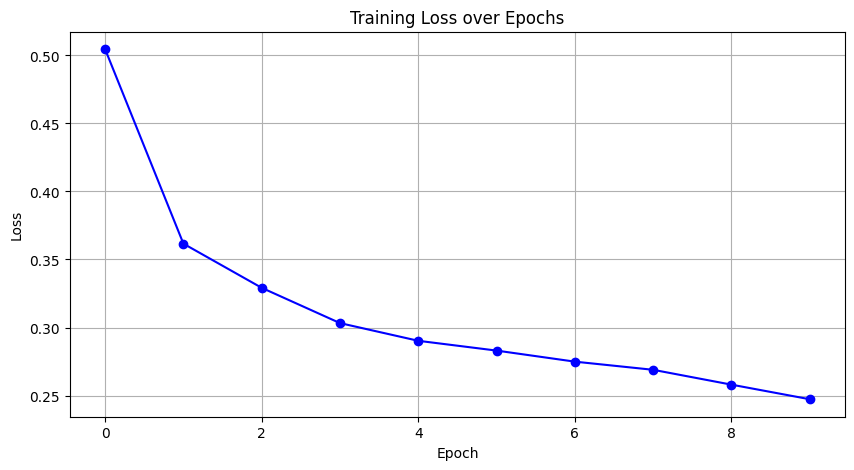

In [ ]:
def bpr_loss(pos_scores, neg_scores):
    return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

def infonce_loss(graph_emb, text_emb, temperature=0.1):
    graph_emb = F.normalize(graph_emb, dim=1)
    text_emb = F.normalize(text_emb, dim=1)
    logits = torch.matmul(graph_emb, text_emb.T) / temperature
    labels = torch.arange(logits.shape[0]).to(logits.device)
    return F.cross_entropy(logits, labels)


# Load Data
g, mappings, train_df, test_df = load_data_and_build_graph()
g = g.to(device)

# Load Text
ov_data, rev_data, mask_data = align_text_embeddings(mappings['movie_map'], TEXT_EMBED_PATH)
ov_data, rev_data, mask_data = ov_data.to(device), rev_data.to(device), mask_data.to(device)

# Setup Loader
dataset = RecommendationDataset(train_df, mappings['user_map'], mappings['movie_map'])
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize Model
text_dim = ov_data.shape[1]
model = KnowledgeAwareRecommender(g, text_dim, HIDDEN_DIM, ATTENTION_HEADS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training
print("Starting Training...")
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for users, pos_items, neg_items in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        users, pos_items, neg_items = users.to(device), pos_items.to(device), neg_items.to(device)
        
        # Get batch text
        pos_ov, pos_rev, pos_mask = ov_data[pos_items], rev_data[pos_items], mask_data[pos_items]
        neg_ov, neg_rev, neg_mask = ov_data[neg_items], rev_data[neg_items], mask_data[neg_items]
        
        # Forward
        pos_scores, _, pos_i_g, pos_i_t = model(g, users, pos_items, pos_ov, pos_rev, pos_mask)
        neg_scores, _, _, _ = model(g, users, neg_items, neg_ov, neg_rev, neg_mask)
        
        loss = bpr_loss(pos_scores, neg_scores) + 0.1 * infonce_loss(pos_i_g, pos_i_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Generate Evaluation Data
recs = generate_recommendations(model, g, mappings, ov_data, rev_data, mask_data, train_df, k=50)

# Eval Structures
gt, pop, feats, all_items = prepare_eval_data(train_df, test_df, pd.read_csv('../data/processed/movies_graph_ready.csv'), mappings)

print("\n--- Evaluation Structures Ready ---")
print(f"Recommendations: {len(recs)} users")
print(f"Ground Truth: {len(gt)} users")
print(f"Popularity Dict: {len(pop)} items")
print(f"Item Features: {len(feats)} items")


results = evaluate_recommendations(recs, gt, [10, 20, 50], pop, feats, all_items)
print_evaluation_results(results)

Generating Recommendations...


100%|██████████| 10/10 [00:00<00:00, 12.52it/s]
/tmp/ipykernel_93007/2574588468.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['movie_id'].astype(str), x['rating'])))


Constructing Evaluation Dictionaries...

--- Evaluation Structures Ready ---
Recommendations: 943 users
Ground Truth: 456 users
Popularity Dict: 1650 items
Item Features: 1638 items

RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.1575
  @20: 0.2192
  @50: 0.3498

F1:
  @10: 0.2024
  @20: 0.2216
  @50: 0.2196

INTRA LIST SIMILARITY:
  @10: 1.0000
  @20: 1.0000
  @50: 1.0000

MAP:
  @10: 0.4867
  @20: 0.4375
  @50: 0.3634

MRR:
  @10: 0.5691
  @20: 0.5742
  @50: 0.5757

NDCG:
  @10: 0.3489
  @20: 0.3434
  @50: 0.3694

NOVELTY:
  @10: 8.3365
  @20: 8.5232
  @50: 8.8253

PRECISION:
  @10: 0.2987
  @20: 0.2501
  @50: 0.1804

RECALL:
  @10: 0.1676
  @20: 0.2607
  @50: 0.4317

